In [239]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import optuna
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [240]:
#El archivo se puede bajar directamente del conjunto de datos 
# Carga de la data
test_data_path = r'C:\Users\durrego\Downloads\UNAD\DatosalaU\Registro_Nacional_de_Despachos_de_Carga_por_Carretera_20241111.csv'
df = pd.read_csv(test_data_path)

C:\Users\durrego\AppData\Local\Temp\ipykernel_24768\1838531920.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(test_data_path)


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136062 entries, 0 to 1136061
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   AÑO                     1136062 non-null  object
 1   COD_CONFIG_VEHICULO     1136062 non-null  object
 2   CONFIG_VEHICULO         1135944 non-null  object
 3   CODOPERACIONTRANSPORTE  1136062 non-null  object
 4   OPERACIONTRANSPORTE     1136062 non-null  object
 5   CODTIPOCONTENEDOR       1136062 non-null  object
 6   TIPOCONTENEDOR          1136062 non-null  object
 7   CODMUNICIPIOORIGEN      1136062 non-null  int64 
 8   MUNICIPIOORIGEN         1136062 non-null  object
 9   DEPARTAMENTOORIGEN      1136062 non-null  object
 10  CODMUNICIPIODESTINO     1136062 non-null  int64 
 11  MUNICIPIODESTINO        1136062 non-null  object
 12  DEPARTAMENTODESTINO     1136062 non-null  object
 13  CODMERCANCIA            1136062 non-null  object
 14  MERCANCIA         

### Reconocimiento de variables

Se reconoce en la base de datos un total de 22 variables, donde se reconoce

* Información del vehículo (e.g., configuración)
* Tipo de operación de transporte
* Origen y destino de la carga
* Tipo y naturaleza de la carga
* Variables numéricas como el peso en kilogramos, kilómetros recorridos y el valor pagado (VALORESPAGADOS)

Para esto se lleva todas las variables a numéricas, en el caso de las variables tipo texto se hace un labelEncoder para reconocer la relación entre todas estas a través de una correlación

In [242]:
categorical_columns = df.select_dtypes(include='object').columns
#Se confirma que todas la variables sean tipo string de forma consistente
for col in categorical_columns:
    df[col] = df[col].astype(str)

# Se aplica LabelEncoder a cada columna categórica
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  
df.dtypes

AÑO                       int32
COD_CONFIG_VEHICULO       int32
CONFIG_VEHICULO           int32
CODOPERACIONTRANSPORTE    int32
OPERACIONTRANSPORTE       int32
CODTIPOCONTENEDOR         int32
TIPOCONTENEDOR            int32
CODMUNICIPIOORIGEN        int64
MUNICIPIOORIGEN           int32
DEPARTAMENTOORIGEN        int32
CODMUNICIPIODESTINO       int64
MUNICIPIODESTINO          int32
DEPARTAMENTODESTINO       int32
CODMERCANCIA              int32
MERCANCIA                 int32
NATURALEZACARGA           int32
VIAJESTOTALES             int64
KILOGRAMOS                int64
GALONES                   int64
VIAJESLIQUIDOS            int64
VIAJESVALORCERO           int64
KILOMETROS                int64
VALORESPAGADOS            int64
dtype: object

## Correlación

Ahora con estas variables se hace un estimación de la correlación

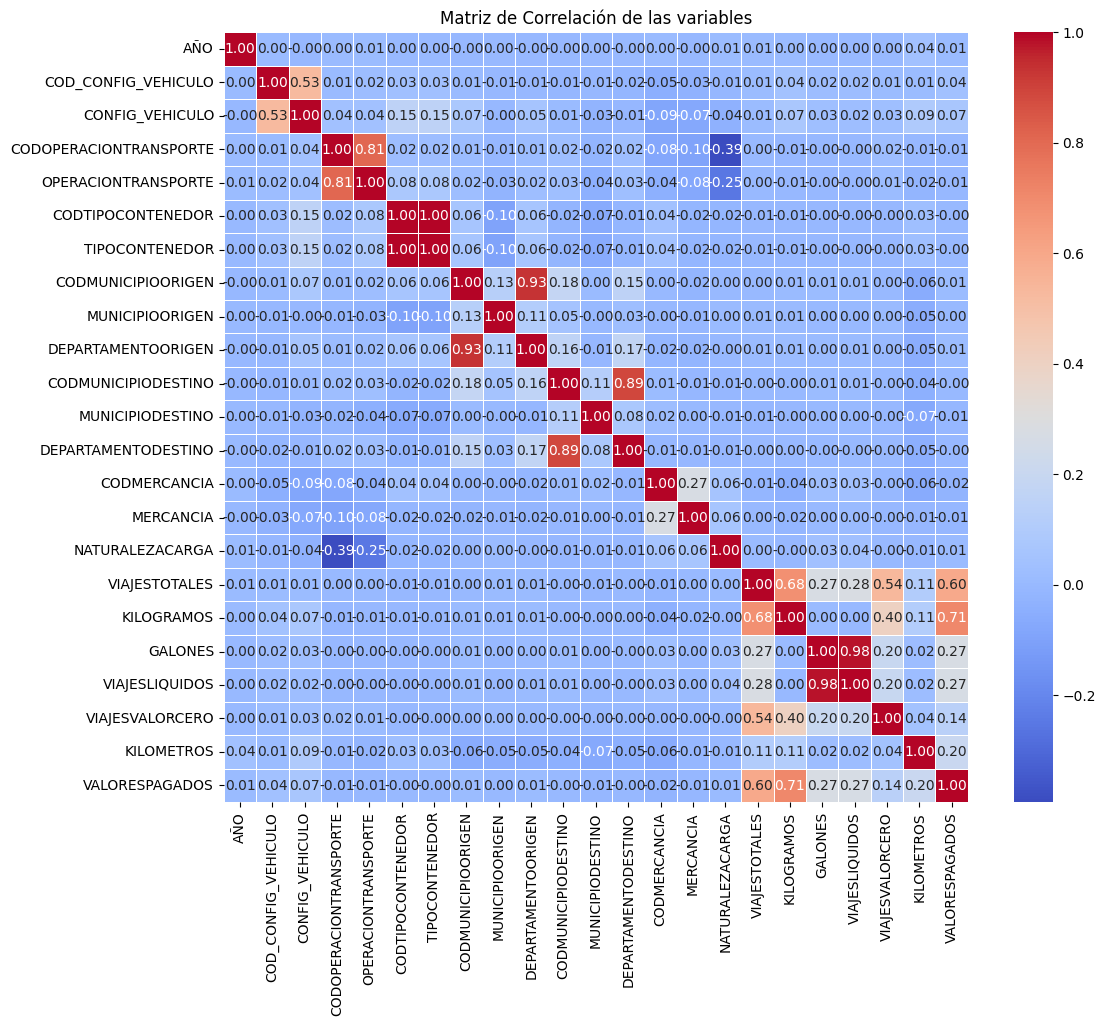

In [243]:
matriz_corr=df.corr()

plt.figure(figsize=(12, 10))
#Mapa de calor de la correlación
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de las variables")
plt.show()

Dado que la variable objetivos es VALORESPAGADOS, se analiza sobre esta la correlación, donde se establece que la guarda mayor relación son las variable de

VIAJESTOTALES y KILOGRAMOS, en este se es de interes la baja correlación de los KILOMETROS, se quiere observa ahora los diferentes datos presentes en esta base de datos y como es su distribución





In [244]:
df.describe()

,AÑO,COD_CONFIG_VEHICULO,CONFIG_VEHICULO,CODOPERACIONTRANSPORTE,OPERACIONTRANSPORTE,CODTIPOCONTENEDOR,TIPOCONTENEDOR,CODMUNICIPIOORIGEN,MUNICIPIOORIGEN,DEPARTAMENTOORIGEN,...,CODMERCANCIA,MERCANCIA,NATURALEZACARGA,VIAJESTOTALES,KILOGRAMOS,GALONES,VIAJESLIQUIDOS,VIAJESVALORCERO,KILOMETROS,VALORESPAGADOS
count,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,...,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06,1.136062e+06
mean,5.664647e-01,9.215285e+00,6.737909e+00,1.028042e+00,4.732400e-02,3.899259e-02,3.899259e-02,3.552029e+07,9.413634e+02,1.373423e+01,...,7.345775e+02,6.022877e+02,3.086512e+00,1.311948e+01,1.669863e+05,6.556567e+03,7.687151e-01,2.433673e+00,9.112801e+02,1.926957e+07
std,4.955630e-01,9.172340e+00,6.923536e+00,2.765449e-01,3.860777e-01,2.116875e-01,2.116875e-01,2.809787e+07,7.168062e+02,1.039326e+01,...,4.612707e+02,3.772716e+02,5.525738e-01,1.135494e+02,2.145871e+06,2.987855e+05,3.111635e+01,4.356338e+01,1.321771e+03,1.932862e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.001000e+06,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100100e+07,2.410000e+02,4.000000e+00,...,3.460000e+02,2.680000e+02,3.000000e+00,1.000000e+00,4.500000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.760000e+02,1.000500e+06
50%,1.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.528600e+07,7.760000e+02,1.400000e+01,...,7.860000e+02,6.320000e+02,3.000000e+00,1.000000e+00,1.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.720000e+02,2.700000e+06
75%,1.000000e+00,1.800000e+01,1.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.808100e+07,1.438000e+03,2.500000e+01,...,1.136000e+03,9.750000e+02,3.000000e+00,4.000000e+00,3.800000e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.026000e+03,7.018610e+06
max,1.000000e+00,3.200000e+01,2.700000e+01,4.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,9.977301e+07,2.290000e+03,3.100000e+01,...,2.057000e+03,1.240000e+03,7.000000e+00,3.181000e+04,6.012580e+08,1.099312e+08,1.136400e+04,1.160900e+04,1.711000e+04,4.434128e+10


### Limpieza y outliers
Se observa en las variables KILOGRAMOS, KILOMETROS y VALORESPAGADOS valores en cero, los que no son de interés, por lo tanto se eliminan.

Ademas se observa una gran variabilidad en estos, datos por ende se hace un estimación de los outliers y se quitan en de los datos

In [245]:
df = df[(df[['VALORESPAGADOS', 'KILOMETROS', 'KILOGRAMOS', 'VIAJESTOTALES']] != 0).all(axis=1)]
df.shape

(965022, 23)

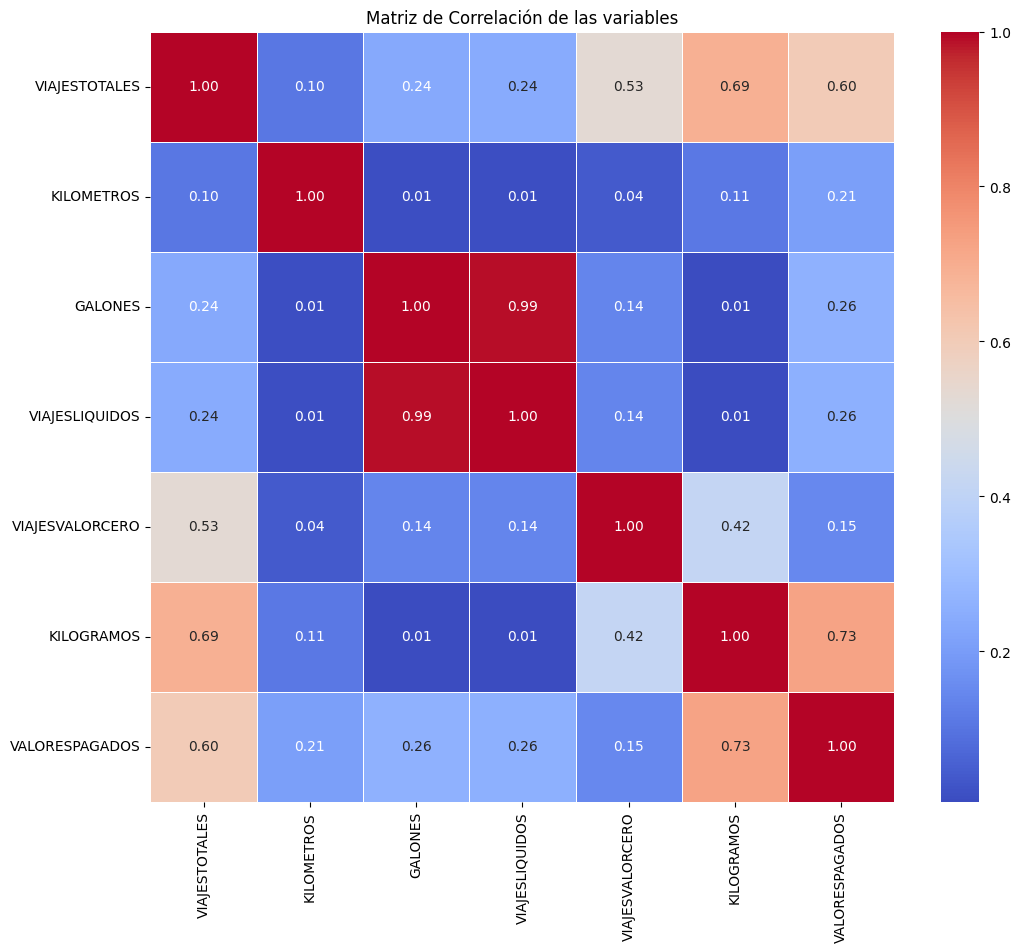

In [246]:
df1 = df[['VIAJESTOTALES','KILOMETROS','GALONES','VIAJESLIQUIDOS','VIAJESVALORCERO','KILOGRAMOS','VALORESPAGADOS']]
matriz_corr=df1.corr()

plt.figure(figsize=(12, 10))
#Mapa de calor de la correlación
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de las variables")
plt.show()

In [247]:
df1.describe()


,VIAJESTOTALES,KILOMETROS,GALONES,VIAJESLIQUIDOS,VIAJESVALORCERO,KILOGRAMOS,VALORESPAGADOS
count,965022.000000,965022.000000,9.650220e+05,965022.000000,965022.000000,9.650220e+05,9.650220e+05
mean,13.647079,994.281003,3.075587e+03,0.334497,1.945715,1.801709e+05,2.104503e+07
std,119.756144,1366.509821,2.653947e+05,27.512140,43.085046,2.293799e+06,2.047008e+08
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,2.000000e+04
25%,1.000000,240.000000,0.000000e+00,0.000000,0.000000,5.000000e+03,1.400000e+06
50%,2.000000,516.000000,0.000000e+00,0.000000,0.000000,1.512800e+04,3.108000e+06
75%,5.000000,1073.000000,0.000000e+00,0.000000,0.000000,4.200000e+04,8.022000e+06
max,31810.000000,17110.000000,1.099312e+08,11364.000000,11609.000000,6.012580e+08,4.434128e+10


## Escalamiento de datos

Dada la variabilidad de los datos tanto de entrenamiento y prueba se define un escalamiento para los datos, esto con el fin de mejorar las condiciones para las siguientes estimaciones del modelo. 

Esta decisión se basa en varios elementos ya que se hicieron multiples pruebas de outliers y los resulatos finales no mejoraron, por lo tanto, se esta estrategia fue la seleccionada.

In [248]:
from sklearn.preprocessing import MinMaxScaler

# Supongamos que df es tu DataFrame original
# Seleccionar las columnas a escalar
columns_to_scale = ['VIAJESTOTALES','KILOMETROS', 'GALONES', 'VIAJESLIQUIDOS', 'VIAJESVALORCERO', 'KILOGRAMOS','VALORESPAGADOS']
#columns_to_scale = ['VIAJESTOTALES','KILOMETROS', 'GALONES', 'VIAJESLIQUIDOS', 'VIAJESVALORCERO', 'KILOGRAMOS']

# Inicializar el escalador
scaler = MinMaxScaler()

# Escalar solo las columnas seleccionadas
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])

df1.head()

C:\Users\durrego\AppData\Local\Temp\ipykernel_24768\3518896232.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])


,VIAJESTOTALES,KILOMETROS,GALONES,VIAJESLIQUIDOS,VIAJESVALORCERO,KILOGRAMOS,VALORESPAGADOS
0,0.000000,0.053422,0.0,0.0,0.0,1.661516e-06,4.690891e-05
1,0.000126,0.081770,0.0,0.0,0.0,1.579854e-05,1.889888e-04
2,0.000063,0.018879,0.0,0.0,0.0,1.496695e-05,5.029176e-05
3,0.000000,0.019580,0.0,0.0,0.0,1.646548e-07,1.127618e-07
4,0.000000,0.018821,0.0,0.0,0.0,2.572939e-06,2.601911e-05


## Prueba de Modelos

Se seleccionan 3 tipos de Regresión Lineal, RandomForest y Gradient Boosting Regresor

In [249]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Variables predictoras (X) y variable objetivo (y)
X = df1.drop(columns=['VALORESPAGADOS'])
y = df1['VALORESPAGADOS']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_RL = LinearRegression()
modelo_RL.fit(X_train, y_train)
    
# Predecir y evaluar
y_pred = modelo_RL.predict(X_test)
# Calcular las métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Raíz del MSE
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0004
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0025
R-squared (R²): 0.7030


C:\Users\durrego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [250]:
# Variables predictoras (X) y variable objetivo (y)
X = df1.drop(columns=['VALORESPAGADOS'])
y = df1['VALORESPAGADOS']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo_GBR = GradientBoostingRegressor(random_state=42)
modelo_GBR.fit(X_train, y_train)
    
# Predecir y evaluar
y_pred = modelo_GBR.predict(X_test)

# Calcular las métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Raíz del MSE
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 0.0002
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0015
R-squared (R²): 0.8978


C:\Users\durrego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [251]:
from sklearn.ensemble import RandomForestRegressor
# Variables predictoras (X) y variable objetivo (y)
X = df1.drop(columns=['VALORESPAGADOS'])
y = df1['VALORESPAGADOS']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestRegressor(random_state=42)
modelo.fit(X_train, y_train)
    
# Predecir y evaluar
y_pred = modelo.predict(X_test)

In [252]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Raíz del MSE
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0001
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0015
R-squared (R²): 0.8911


C:\Users\durrego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Optimización

Dado que el modelo de Gradient Boosting Regressor tuvo el mejor desempeño, se busca hacer una optimización a través de la variación de los hiperparámatros con el fin de encontrar un modelo optimizado

In [254]:
df1.describe()

,VIAJESTOTALES,KILOMETROS,GALONES,VIAJESLIQUIDOS,VIAJESVALORCERO,KILOGRAMOS,VALORESPAGADOS
count,965022.000000,965022.000000,965022.000000,965022.000000,965022.000000,965022.000000,965022.000000
mean,0.000398,0.058056,0.000028,0.000029,0.000168,0.000300,0.000474
std,0.003765,0.079871,0.002414,0.002421,0.003711,0.003815,0.004616
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.013969,0.000000,0.000000,0.000000,0.000008,0.000031
50%,0.000031,0.030101,0.000000,0.000000,0.000000,0.000025,0.000070
75%,0.000126,0.062657,0.000000,0.000000,0.000000,0.000070,0.000180
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [255]:
# Variables predictoras (X) y variable objetivo (y)
X = df1.drop(columns=['VALORESPAGADOS'])
y = df1['VALORESPAGADOS']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesador para escalar características
preprocessor = ColumnTransformer(
    transformers=[('scaler', MinMaxScaler(), X.columns)]
)

# Definir la función objetivo para Optuna
def objective(trial):
    # Espacio de búsqueda de hiperparámetros para GradientBoostingRegressor
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }

    # Crear el modelo GradientBoostingRegressor
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            **params,
            random_state=42
        ))
    ])
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir y evaluar
    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    
    return error

# Crear el estudio y ejecutar la optimización en paralelo usando 12 núcleos
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=4)  # Usa 12 núcleos

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        **best_params,
        random_state=42
    ))
])

best_model.fit(X_train, y_train)

# Guardar el modelo optimizado
joblib.dump(best_model, r'C:\Users\durrego\Downloads\UNAD\DatosalaU\model_GB_optuna_optimized.joblib')

[I 2024-11-12 04:07:25,385] A new study created in memory with name: no-name-57cb9064-e19b-4710-b9d9-b3093f783df6
[I 2024-11-12 04:12:23,043] Trial 1 finished with value: 2.1903035319364138e-06 and parameters: {'n_estimators': 142, 'learning_rate': 0.023536429451439026, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 14, 'subsample': 0.9039592132365801, 'max_features': 0.6946801647965222}. Best is trial 1 with value: 2.1903035319364138e-06.
[I 2024-11-12 04:13:45,325] Trial 3 finished with value: 1.8230685910826857e-06 and parameters: {'n_estimators': 427, 'learning_rate': 0.023503006933056125, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 7, 'subsample': 0.6194415073978563, 'max_features': 0.8084332390411368}. Best is trial 3 with value: 1.8230685910826857e-06.
[I 2024-11-12 04:13:47,664] Trial 2 finished with value: 2.059036543508399e-06 and parameters: {'n_estimators': 407, 'learning_rate': 0.15946613430992118, 'max_depth': 4, 'min_samples_split': 18, 'mi

Mejores hiperparámetros: {'n_estimators': 104, 'learning_rate': 0.0718487423621087, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 6, 'subsample': 0.8927271689168558, 'max_features': 0.6768472781532977}


['C:\\Users\\durrego\\Downloads\\UNAD\\DatosalaU\\model_GB_optuna_optimized.joblib']

In [261]:
# Realizar predicciones
y_pred = best_model.predict(X_test)

# Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Raíz del MSE
r2 = r2_score(y_test, y_pred)

# Mostrar las métricas
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Mean Absolute Error (MAE): 0.000151
Mean Squared Error (MSE): 0.000002
Root Mean Squared Error (RMSE): 0.001309
R-squared (R²): 0.920474


C:\Users\durrego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Se establece un excelente resultado el cual se almacena, ahora se hace varias gráficas para reconocer las características del modelo

In [257]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,explained_variance_score

file = r'C:\Users\durrego\Downloads\UNAD\DatosalaU\model_GB_optuna_optimized.joblib'


model = joblib.load(file)

non_zero_indices = y_test != 0
y_test_non_zero = y_test[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]
# Calcular MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calcular MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calcular R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calcular el MAPE solo para los valores no cero
mape_non_zero = np.mean(np.abs((y_test_non_zero - y_pred_non_zero) / y_test_non_zero)) * 100

print(f"Mean Absolute Percentage Error (MAPE) excluyendo ceros: {mape_non_zero}%")

evs = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score: {evs}")

Mean Absolute Error (MAE): 0.00015091090832399588
Mean Squared Error (MSE): 1.714777173873101e-06
R-squared (R²): 0.9204740531446559
Root Mean Squared Error (RMSE): 0.001309495007196706
Mean Absolute Percentage Error (MAPE): inf%
Mean Absolute Percentage Error (MAPE) excluyendo ceros: 182.9902398818849%
Explained Variance Score: 0.9204742089144493


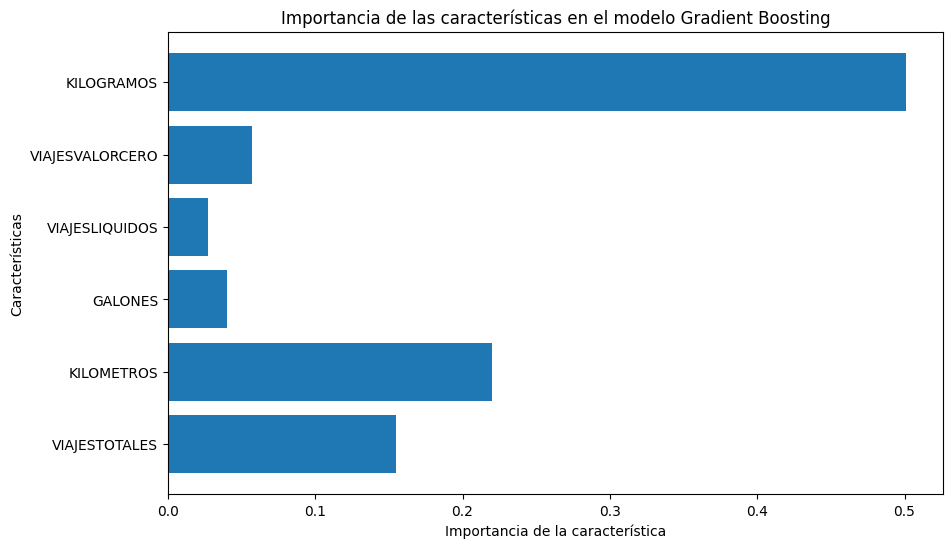

In [258]:
importances = best_model.steps[1][1].feature_importances_

features = ['VIAJESTOTALES','KILOMETROS', 'GALONES', 'VIAJESLIQUIDOS', 'VIAJESVALORCERO', 'KILOGRAMOS']

# Crear un gráfico de barras para visualizar las importancias
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importancia de la característica")
plt.ylabel("Características")
plt.title("Importancia de las características en el modelo Gradient Boosting")
plt.show()

* La característica más importante son los kilogramos, luego este es un factor determinante para predecir el costo, lo que tiene sentido en un contexto de transporte de carga, donde influye directamente
* Los kilómetros, tambien es una característica relevante, siendo tambien un factor critico que puede aumentar los costos.
* Para las variable VIAJESTOTALES y VIAJESVALORCERO, tiene su influencia y aportar a los costos

## Predicciones

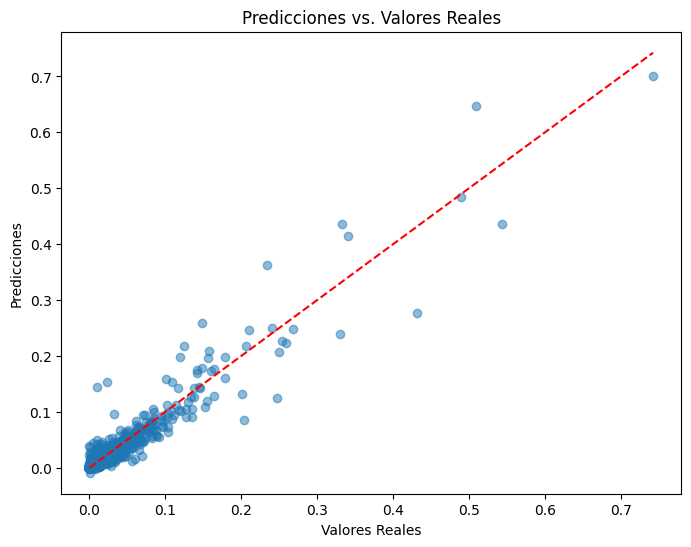

In [259]:
# Suponiendo que tienes y_test (valores reales) y y_pred (predicciones)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Línea diagonal
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales')
plt.show()

* Se reconoce que los valores de distribución estan cercanos a la diagonal, siendo este un excelente resultado, la cercanía sugiere que el modelo es preciso para lo datos con los que se esta probando.
* Se puede obsevar que en valores más altos, la desviación es mayor, no hay un ajuste tan claro en esta zona, esto debido a que seguramente se tienen outliers que modifican el resultado.
* La mayoría de los puntos estan en una tendencia ascendente, lo que puede sugerir que el modelo captura la relación general entre las características de entrada y la variable objetivo
* En valores bajos los errores son pequeños, dada la concentración al rededor de la línea diagonal, en valores más pequeños el modelo es más preciso.

## Residuos

Ahora para los residuos se tiene la siguente gráfica

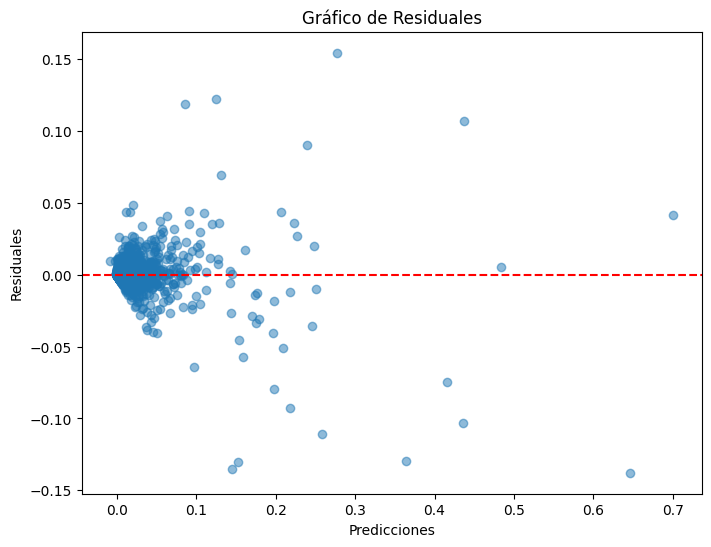

In [260]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.title('Gráfico de Residuales')
plt.show()


* Se observa en la gráfica una concentración de residuos en los valores bajos, en su mayoria se concentran cerca de cero, lo que indica que el modelo tiene predicciones razonables para valores bajos de la variable objetivo. La concentración es una buena señal, ya que se puede estimar que el modelo no tiene un sesgo sistémico en los valores bajos
* A medida que las predicciones aumentan, se observa una mayor dispersión en los residuos, tanto para valores positivos como negativos, esto muestra que el modelo tiene dificultad para predicir valores altos, resultando en errores grandes. Puede establecerse que el modelo no captura toda la variabilidad de los datos en rangos altos.
* El residuos aumenta con la predicción, lo que puede sugerir una heteocedasticidad, el error no es constante a lo largo de las predicciones.
* No se reconoce un patrón claro en los residuos, lo que se puede considerar positivo, esto indica que no hay un sesgo direccional fuerte y que estos parecen aleatorios.


## Conclusiones

* Se logra reconocer un modelo preciso, las métricas muestran que la predicción es precisa, con un R2 de 0.92, indica que el modelo explica la variabilidad en los valores a pagar

* Las variables más relevantes son KILOGRAMOS y KILOMETROS, el modelo esta alineado con la lógica del transporte de carga, donde el peso y la distancia, son factores determinantes en los precios y es consistente con la realidad del sector de carga en el país.

* Se pueden establecer mejoras, en cuanto a los valores a pagar altos, se puede ajustar el modelo para mejorar la precisión a través de un análisis más exhaustivo y considerar elementos como la transformación de los datos y características para aplicar otros tipos de análisis

* El modelo es eficiente en predecir valores bajos, la dipersión de los residuos indica que el modelo es bueno para valores a pagar bajos, que en el sentido práctico es la mayoría de viajes que se puede encontra en los datos
